In [1]:
%load_ext autoreload
%autoreload 2

from circuit_breaking.src import *
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from circuit_breaking.src.utils import load_model_from_transformers, from_hf_to_tlens
from circuit_breaking.src.masks import MLPHiddenMask
from tqdm.auto import tqdm
#torch.autograd.set_detect_anomaly(True) 

In [2]:
from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoTokenizer
model_name_or_path = "google/gemma-7b"
model_type = "gemma"

tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b")
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

model = HookedTransformer.from_pretrained(
    'google/gemma-7b',
    tokenizer=tokenizer,
    device='cuda',
    default_padding_side="right",
    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    dtype=torch.bfloat16
)

model.set_use_attn_result(True)

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-7b into HookedTransformer


In [3]:
import pickle
with open("models/google_gemma-7b_sports_all_ap_graph.pkl", "rb") as f:
    ap_graph = pickle.load(f)
ap_graph.keys()

dict_keys(['a0.0_q', 'a0.1_q', 'a0.2_q', 'a0.3_q', 'a0.4_q', 'a0.5_q', 'a0.6_q', 'a0.7_q', 'a0.8_q', 'a0.9_q', 'a0.10_q', 'a0.11_q', 'a0.12_q', 'a0.13_q', 'a0.14_q', 'a0.15_q', 'a0.0_k', 'a0.1_k', 'a0.2_k', 'a0.3_k', 'a0.4_k', 'a0.5_k', 'a0.6_k', 'a0.7_k', 'a0.8_k', 'a0.9_k', 'a0.10_k', 'a0.11_k', 'a0.12_k', 'a0.13_k', 'a0.14_k', 'a0.15_k', 'a0.0_v', 'a0.1_v', 'a0.2_v', 'a0.3_v', 'a0.4_v', 'a0.5_v', 'a0.6_v', 'a0.7_v', 'a0.8_v', 'a0.9_v', 'a0.10_v', 'a0.11_v', 'a0.12_v', 'a0.13_v', 'a0.14_v', 'a0.15_v', 'a0.0_result', 'a0.1_result', 'a0.2_result', 'a0.3_result', 'a0.4_result', 'a0.5_result', 'a0.6_result', 'a0.7_result', 'a0.8_result', 'a0.9_result', 'a0.10_result', 'a0.11_result', 'a0.12_result', 'a0.13_result', 'a0.14_result', 'a0.15_result', 'a1.0_q', 'a1.1_q', 'a1.2_q', 'a1.3_q', 'a1.4_q', 'a1.5_q', 'a1.6_q', 'a1.7_q', 'a1.8_q', 'a1.9_q', 'a1.10_q', 'a1.11_q', 'a1.12_q', 'a1.13_q', 'a1.14_q', 'a1.15_q', 'a1.0_k', 'a1.1_k', 'a1.2_k', 'a1.3_k', 'a1.4_k', 'a1.5_k', 'a1.6_k', 'a1.7_k',

In [4]:
from tasks import PileTask, OWTTask, InductionTask, GreaterThanTask
from tasks.ioi.IOITask import IOITask, IOITask_NPO, IOITask_Uniform
from tasks.induction.InductionTask import InductionTask, InductionTask_NPO, InductionTask_Uniform
from tasks.facts.SportsTask import SportsTask, SportsTask_NPO, SportsTask_Uniform
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval
from tasks.facts.SportsTaskSideEffects import run_side_effects_evals


train_batch_size = 8
eval_batch_size=32

device = "cuda"
train_loss_type = "sports"
forget_sport = "basketball"
maintain_sport = None
# val_sport = "baseball"


sports_1mp = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="log_1_minus_p", forget_sport_subset={forget_sport}, is_forget_dataset=True)

if maintain_sport is None:
    maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={forget_sport}, is_forget_dataset=False)
else:
    maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={maintain_sport}, is_forget_dataset=True)

train_pile = PileTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, ctx_length=256, shuffle=True, buffer_size=50000)
train_tasks = {"sports_1mp": (sports_1mp, .2), "maintain_sports": (maintain_sports, 1), "pile": (train_pile, 1)}

# want to eval on other sports
forget_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={forget_sport}, is_forget_dataset=True)
test_pile = PileTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, ctx_length=100, shuffle=True, buffer_size=50000)

induction_eval = InductionTask(batch_size=eval_batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device)
if maintain_sport is None:
    maintain_sports_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={forget_sport}, is_forget_dataset=False)
    eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": forget_sport_eval, "maintain_sport": maintain_sports_eval}
else:
    maintain_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={maintain_sport}, is_forget_dataset=True)
    val_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={val_sport}, is_forget_dataset=True)
    eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": 
                  forget_sport_eval, "maintain_sport": maintain_sport_eval, "val_sport": val_sport_eval}

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


In [5]:
def convert_attrs_to_components(attrs, combine_heads=False, n_layers=model.cfg.n_layers, n_heads=model.cfg.n_heads):
    """
    attrs is dictionary of e.g. {'a0.0_q': float, 'm27_in': float}

    If combine_heads, then it will combine all 'a0.0_q', 'a0.1_q', ..., 'a0.15_q', etc into one component.
    """

    component_dict = defaultdict(int)
    attn_head_dict = defaultdict(dict)
    for layer in range(n_layers):
        for attn_type, component_name in [("q", f"blocks.{layer}.attn.hook_q"), ("k", f"blocks.{layer}.attn.hook_k"), ("v", f"blocks.{layer}.attn.hook_v"), ("result", f"blocks.{layer}.attn.hook_result")]:
            for head in range(n_heads):    
                if combine_heads:
                    component_dict[component_name] += attrs[f"a{layer}.{head}_{attn_type}"]
                else:
                    attn_head_dict[component_name][head] = attrs[f"a{layer}.{head}_{attn_type}"]
        for mlp_type, component_name in [("in", f"blocks.{layer}.mlp.hook_pre"), ("out", f"blocks.{layer}.mlp.hook_post")]:
            component_dict[component_name] += attrs[f"m{layer}_{mlp_type}"]
    if combine_heads:
        return (component_dict,)
    return (component_dict, attn_head_dict,)


def get_top_components(component_dict, attn_head_dict=None, threshold=None, top_p=None, top_k=None, use_abs=True, n_layers=model.cfg.n_layers, n_heads=model.cfg.n_heads):
    """
    component_dict is a dictionary of components to their importance values. If attn_head_dict is not None, then component_dict and attn_head_dict should not overlap in values.

    Can either use a threshold, top_p, or top_k to determine the top components to return (can only specify one). top_p should be a value ranging from 0 to 100. If use_abs is True, then it will take the absolute value of the importance values. 
    """
    if attn_head_dict is not None:
        assert (component_dict.keys() & attn_head_dict.keys()) == set(), "Overlapping keys between component_dict and attn_head_dict"
    
    # assert only one of threshold, top_p, top_k is specified
    assert sum([threshold is not None, top_p is not None, top_k is not None]) == 1, "Can only specify one of threshold, top_p, top_k"
    # will calculate a threshold for top_p or top_k

    if top_p is not None:
        all_attr_values = list(component_dict.values())
        if attn_head_dict is not None:
            all_attr_values += [val for head_dict in attn_head_dict.values() for val in head_dict.values()]

        all_attr_values = np.array(all_attr_values)
        if use_abs:
            all_attr_values = np.abs(all_attr_values)
        print(f"{len(all_attr_values)=}")
        threshold = np.percentile(all_attr_values, 100 - top_p)
    elif top_k is not None:
        all_attr_values = list(component_dict.values())
        if attn_head_dict is not None:
            all_attr_values += [val for head_dict in attn_head_dict.values() for val in head_dict.values()]

        all_attr_values = np.array(all_attr_values)
        if use_abs:
            all_attr_values = np.abs(all_attr_values)
        threshold = np.sort(all_attr_values)[-top_k]
    
    print(f"Thresholding importance at {threshold}")
    final_components = []
    final_attn_heads = defaultdict(list)

    for component, importance in component_dict.items():
        if use_abs:
            importance = abs(importance)
        if importance >= threshold:
            final_components.append(component)    

    if attn_head_dict is not None:
        for component, head_dict in attn_head_dict.items():
            head_list = []
            for head, importance in head_dict.items():
                if use_abs:
                    importance = abs(importance)
                if importance >= threshold:
                    head_list.append(head)
            if len(head_list) > 0:
                final_attn_heads[component] = head_list
                final_components.append(component)
    else:
        for component in final_components:
            if "attn" in component:
                # want to mask over all possible heads
                final_attn_heads[component] = list(range(n_heads))
    
    return final_components, final_attn_heads
print(get_top_components(*convert_attrs_to_components(ap_graph, combine_heads=True), top_p=5))
print(get_top_components(*convert_attrs_to_components(ap_graph, combine_heads=False), top_k=20))


len(all_attr_values)=168
Thresholding importance at 0.20463522672653203
(['blocks.18.attn.hook_result', 'blocks.21.mlp.hook_pre', 'blocks.21.mlp.hook_post', 'blocks.23.mlp.hook_post', 'blocks.25.attn.hook_result', 'blocks.25.mlp.hook_pre', 'blocks.27.attn.hook_q', 'blocks.27.attn.hook_k', 'blocks.27.mlp.hook_post'], defaultdict(<class 'list'>, {'blocks.18.attn.hook_result': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'blocks.25.attn.hook_result': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'blocks.27.attn.hook_q': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'blocks.27.attn.hook_k': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}))
Thresholding importance at 0.11414513221153846
(['blocks.0.mlp.hook_pre', 'blocks.13.mlp.hook_pre', 'blocks.19.mlp.hook_pre', 'blocks.20.mlp.hook_post', 'blocks.21.mlp.hook_pre', 'blocks.21.mlp.hook_post', 'blocks.22.mlp.hook_post', 'blocks.23.mlp.hook_pre', 'blocks.23.mlp.hook_post', 'blocks.25.mlp.hook_pre', 'bloc

## Train Masks

In [ ]:
use_localized_mask = True

combine_heads = False
top_p = 5

if use_localized_mask:
    final_components, final_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, combine_heads=combine_heads), top_p=top_p)

    print(final_components)
    print(final_attn_heads)

    mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)

else:
    all_components, all_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, combine_heads=combine_heads), top_p=100)
    print(len(all_components))
    print(len(all_attn_heads))
    assert (torch.tensor([len(x) for x in all_attn_heads.values()]) == model.cfg.n_heads).all()

    mask = NeuronLevelMask(model, components=all_components, component_heads=all_attn_heads)


len(all_attr_values)=1848
Thresholding importance at 0.0332934452937199
['blocks.0.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.2.mlp.hook_post', 'blocks.4.mlp.hook_pre', 'blocks.5.mlp.hook_pre', 'blocks.10.mlp.hook_pre', 'blocks.11.mlp.hook_post', 'blocks.12.mlp.hook_pre', 'blocks.12.mlp.hook_post', 'blocks.13.mlp.hook_pre', 'blocks.13.mlp.hook_post', 'blocks.14.mlp.hook_pre', 'blocks.14.mlp.hook_post', 'blocks.15.mlp.hook_pre', 'blocks.15.mlp.hook_post', 'blocks.16.mlp.hook_pre', 'blocks.17.mlp.hook_post', 'blocks.18.mlp.hook_pre', 'blocks.18.mlp.hook_post', 'blocks.19.mlp.hook_pre', 'blocks.20.mlp.hook_pre', 'blocks.20.mlp.hook_post', 'blocks.21.mlp.hook_pre', 'blocks.21.mlp.hook_post', 'blocks.22.mlp.hook_pre', 'blocks.22.mlp.hook_post', 'blocks.23.mlp.hook_pre', 'blocks.23.mlp.hook_post', 'blocks.24.mlp.hook_pre', 'blocks.24.mlp.hook_post', 'blocks.25.mlp.hook_pre', 'blocks.25.mlp.hook_post', 'blocks.26.mlp.hook_pre', 'blocks.26.mlp.hook_post', 'blocks.27.mlp.hook_pre', 'block

In [ ]:
# mask = MLPHiddenMask(model).cuda()

learning_rate = 5e-2
n_epochs = 50
grad_accum_steps = 16
# max_gpu_batch_size=8
beta = 10
clip_grad = 1

evaluate_every = 5
n_eval_iters = 5
deep_evaluate_every = 10
do_adversarial_evals = True
do_side_effects_evals = False

from collections import defaultdict
all_train_losses = defaultdict(list)
all_test_losses = defaultdict(list)
adversarial_evals = []
side_effect_evals = []
mask.cuda()

# Initialize optimizer

optimizer = torch.optim.AdamW(mask.parameters(), lr=learning_rate, weight_decay=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_epochs)
# Cycle dataloaders
# Train a sparse mask
pbar = tqdm(range(n_epochs))
for epoch in pbar:
    # Sample batches
    # Reset grad
    optimizer.zero_grad()
    # Compute normal loss over retain
    for task_name, (task, task_weight) in train_tasks.items():
        task_loss = 0
        for i in range(grad_accum_steps):
            loss = task.get_train_loss(model) / grad_accum_steps
            task_loss += loss.item()
            loss *= task_weight
            loss.backward()
        all_train_losses[task_name].append(task_loss)
        
    # Add sparsity loss and backprop
    loss = beta * mask.regularization_loss()
    loss.backward()
    all_train_losses["reg"].append(loss.item())
    # Step and log
    if clip_grad is not None:
        torch.nn.utils.clip_grad_norm_(mask.parameters(), clip_grad)
    # zero_nan_grads(mask)
    optimizer.step()
    mask.on_step_end()
    scheduler.step()

    if epoch % evaluate_every == 0 or epoch == n_epochs - 1:
        for task_name, task in eval_tasks.items():
            task_loss = 0
            for i in range(n_eval_iters):
                task_loss += task.get_test_loss(model).item()
            all_test_losses[task_name].append(task_loss / n_eval_iters)
    if epoch % deep_evaluate_every == 0 or epoch == n_epochs - 1:
        if do_adversarial_evals:
            print("Running adversarial evals")
            adversarial_evals.append(adversarial_sports_eval(model, model_type=model_type, batch_size=eval_batch_size, use_system_prompt=True))
        if do_side_effects_evals:
            print("Running side effects evals")
            side_effect_evals.append(run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["Sports Answers"]))
    

  0%|          | 0/50 [00:00<?, ?it/s]

Running adversarial evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running adversarial evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running adversarial evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running adversarial evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running adversarial evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running adversarial evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# save masks state dict to neuron_cb
import pickle
torch.save(mask.state_dict(), f"masks/neuron_cb/{model_type}_{'localized' if use_localized_mask else 'nonlocalized'}_{combine_heads=}_unlearn_{forget_sport}.pt")

with open(f"masks/neuron_cb/{model_type}_{'localized' if use_localized_mask else 'nonlocalized'}_{combine_heads=}_unlearn_{forget_sport}_metrics.pkl", "wb") as f:
    pickle.dump({"train_losses": all_train_losses, "test_losses": all_test_losses, "adversarial_evals": adversarial_evals, "side_effect_evals": side_effect_evals}, f)

## Analyze Mask

In [7]:
localized_model = model
nonlocalized_model = HookedTransformer.from_pretrained(
    'google/gemma-7b',
    tokenizer=tokenizer,
    device='cuda',
    default_padding_side="right",
    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    dtype=torch.bfloat16
)

nonlocalized_model.set_use_attn_result(True)

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-7b into HookedTransformer


In [8]:
# use_localized_mask = False

combine_heads = False
top_p = 5

# if use_localized_mask:
final_components, final_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, combine_heads=combine_heads), top_p=top_p)

print(final_components)
print(final_attn_heads)

localized_mask = NeuronLevelMask(localized_model, components=final_components, component_heads=final_attn_heads)


all_components, all_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, combine_heads=combine_heads), top_p=100)
print(len(all_components))
print(len(all_attn_heads))
assert (torch.tensor([len(x) for x in all_attn_heads.values()]) == model.cfg.n_heads).all()

nonlocalized_mask = NeuronLevelMask(nonlocalized_model, components=all_components, component_heads=all_attn_heads)

# mask.load_state_dict(torch.load(f"masks/neuron_cb/{model_type}_{'localized' if use_localized_mask else 'nonlocalized'}_{combine_heads=}_unlearn_{forget_sport}.pt"))
localized_mask.load_state_dict(torch.load(f"masks/neuron_cb/{model_type}_localized_{combine_heads=}_unlearn_{forget_sport}.pt"))
nonlocalized_mask.load_state_dict(torch.load(f"masks/neuron_cb/{model_type}_nonlocalized_{combine_heads=}_unlearn_{forget_sport}.pt"))

localized_mask.cuda()
nonlocalized_mask.cuda()

len(all_attr_values)=1848
Thresholding importance at 0.0332934452937199
['blocks.0.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.2.mlp.hook_post', 'blocks.4.mlp.hook_pre', 'blocks.5.mlp.hook_pre', 'blocks.10.mlp.hook_pre', 'blocks.11.mlp.hook_post', 'blocks.12.mlp.hook_pre', 'blocks.12.mlp.hook_post', 'blocks.13.mlp.hook_pre', 'blocks.13.mlp.hook_post', 'blocks.14.mlp.hook_pre', 'blocks.14.mlp.hook_post', 'blocks.15.mlp.hook_pre', 'blocks.15.mlp.hook_post', 'blocks.16.mlp.hook_pre', 'blocks.17.mlp.hook_post', 'blocks.18.mlp.hook_pre', 'blocks.18.mlp.hook_post', 'blocks.19.mlp.hook_pre', 'blocks.20.mlp.hook_pre', 'blocks.20.mlp.hook_post', 'blocks.21.mlp.hook_pre', 'blocks.21.mlp.hook_post', 'blocks.22.mlp.hook_pre', 'blocks.22.mlp.hook_post', 'blocks.23.mlp.hook_pre', 'blocks.23.mlp.hook_post', 'blocks.24.mlp.hook_pre', 'blocks.24.mlp.hook_post', 'blocks.25.mlp.hook_pre', 'blocks.25.mlp.hook_post', 'blocks.26.mlp.hook_pre', 'blocks.26.mlp.hook_post', 'blocks.27.mlp.hook_pre', 'block

NeuronLevelMask(
  (masks): ParameterDict(
      (blocks&0&mlp&hook_pre): Parameter containing: [torch.cuda.FloatTensor of size 24576 (cuda:0)]
      (blocks&0&mlp&hook_post): Parameter containing: [torch.cuda.FloatTensor of size 24576 (cuda:0)]
      (blocks&1&mlp&hook_pre): Parameter containing: [torch.cuda.FloatTensor of size 24576 (cuda:0)]
      (blocks&1&mlp&hook_post): Parameter containing: [torch.cuda.FloatTensor of size 24576 (cuda:0)]
      (blocks&2&mlp&hook_pre): Parameter containing: [torch.cuda.FloatTensor of size 24576 (cuda:0)]
      (blocks&2&mlp&hook_post): Parameter containing: [torch.cuda.FloatTensor of size 24576 (cuda:0)]
      (blocks&3&mlp&hook_pre): Parameter containing: [torch.cuda.FloatTensor of size 24576 (cuda:0)]
      (blocks&3&mlp&hook_post): Parameter containing: [torch.cuda.FloatTensor of size 24576 (cuda:0)]
      (blocks&4&mlp&hook_pre): Parameter containing: [torch.cuda.FloatTensor of size 24576 (cuda:0)]
      (blocks&4&mlp&hook_post): Parameter co

In [9]:
for name, param in localized_mask.named_parameters():
    print(name, param.shape, param.requires_grad, param.sum().item())
print("\n\n")
for name, param in nonlocalized_mask.named_parameters():
    print(name, param.shape, param.requires_grad, param.sum().item())



masks.blocks&0&mlp&hook_pre torch.Size([24576]) True 24535.658203125
masks.blocks&1&mlp&hook_post torch.Size([24576]) True 24561.6015625
masks.blocks&2&mlp&hook_post torch.Size([24576]) True 24575.53125
masks.blocks&4&mlp&hook_pre torch.Size([24576]) True 24570.39453125
masks.blocks&5&mlp&hook_pre torch.Size([24576]) True 24573.6875
masks.blocks&10&mlp&hook_pre torch.Size([24576]) True 24575.58984375
masks.blocks&11&mlp&hook_post torch.Size([24576]) True 24575.61328125
masks.blocks&12&mlp&hook_pre torch.Size([24576]) True 24575.318359375
masks.blocks&12&mlp&hook_post torch.Size([24576]) True 24575.626953125
masks.blocks&13&mlp&hook_pre torch.Size([24576]) True 24575.212890625
masks.blocks&13&mlp&hook_post torch.Size([24576]) True 24575.56640625
masks.blocks&14&mlp&hook_pre torch.Size([24576]) True 24575.69921875
masks.blocks&14&mlp&hook_post torch.Size([24576]) True 24575.755859375
masks.blocks&15&mlp&hook_pre torch.Size([24576]) True 24575.779296875
masks.blocks&15&mlp&hook_post torch

In [10]:
(localized_mask.masks['blocks&0&mlp&hook_pre'] != 1).sum()

tensor(166, device='cuda:0')

In [11]:

# with open(f"masks/neuron_cb/{model_type}_{'localized' if use_localized_mask else 'nonlocalized'}_{combine_heads=}_unlearn_{forget_sport}_metrics.pkl", "rb") as f:
#     metrics = pickle.load(f)

# metrics['test_losses']['pile']

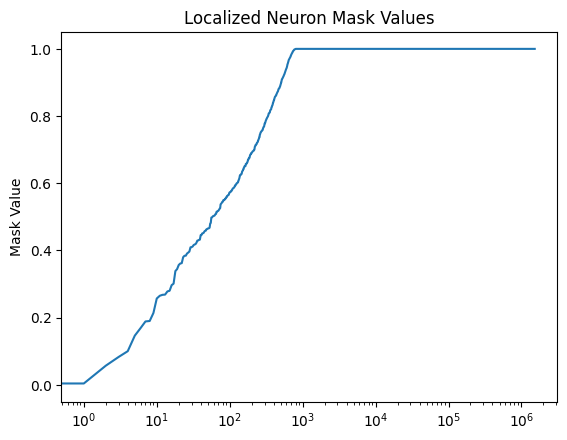

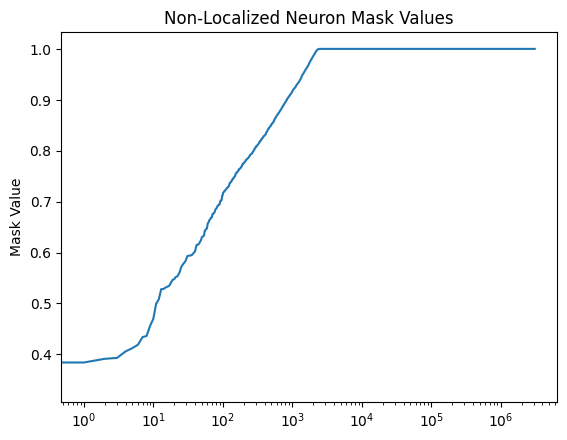

In [12]:
# Visualize the neuron coefficients
for title, mask in [("Localized", localized_mask), ("Non-Localized", nonlocalized_mask)]:
    all_values = torch.cat([m.data.flatten() for m in mask.masks.values()], dim=0).cpu()
    sorted_values = all_values.sort().values
    plt.semilogx(sorted_values)
    plt.title(f"{title} Neuron Mask Values")
    plt.ylabel("Mask Value")
    plt.show()
# all_values = torch.cat([m.data.flatten() for m in mask.masks.values()], dim=0).cpu()
# sorted = all_values.sort().values
# plt.semilogx(sorted)
# plt.title("Neuron Mask Values")
# plt.ylabel("Mask Value")
# plt.show()

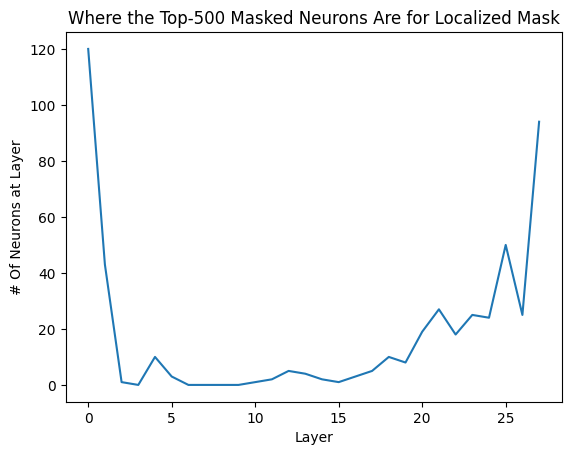

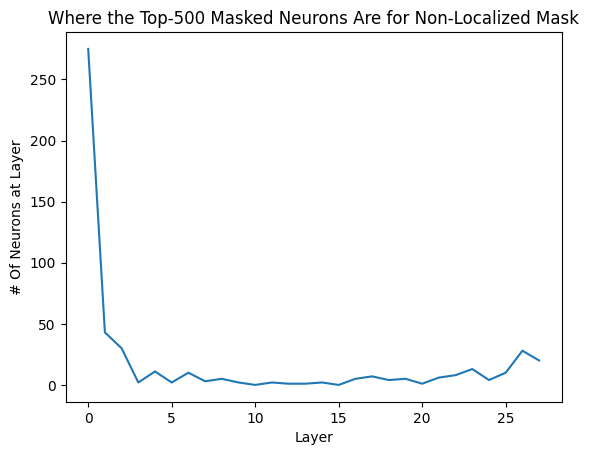

In [13]:
# Visualize the neuron coefficients
top_k = 500
for title, mask in [("Localized", localized_mask), ("Non-Localized", nonlocalized_mask)]:
    mask.undiscretize()
    mask.discretize_topk(top_k)
    all_values = {layer: 0 for layer in range(model.cfg.n_layers)}
    for component in mask.mask_masks:
        layer = int(component.split("&")[1])
        all_values[layer] += (mask.mask_masks[component].data == 1).sum().item()

    # all_values = [(m.data == 1).sum().item() for m in mask.mask_masks.values()]
    plt.plot(all_values.values())
    plt.title(f"Where the Top-{top_k} Masked Neurons Are for {title} Mask")
    plt.ylabel("# Of Neurons at Layer")
    plt.xlabel("Layer")
    plt.show()

In [14]:
torch.cuda.empty_cache()
torch.cuda.memory_allocated() // 1024 // 1024 // 1024

38

In [15]:
# Final evals
for title, mask in [("Localized", localized_mask), ("Non-Localized", nonlocalized_mask)]:
    print(f"Final evals for {title} Mask")
    mask.undiscretize()
    final_adversarial_eval = adversarial_sports_eval(model, model_type=model_type, batch_size=eval_batch_size, use_system_prompt=True, continuous=False)
    print(f"System Prompt: adversarial evals are {final_adversarial_eval}")
    final_adversarial_eval = adversarial_sports_eval(model, model_type=model_type, batch_size=eval_batch_size, use_system_prompt=False, continuous=False)
    print(f"No System Prompt: adversarial evals are {final_adversarial_eval}")

    final_side_effects = run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["Sports Answers", "Cross Entropy"], verbose=True)
    print(final_side_effects)

Final evals for Localized Mask
System Prompt: adversarial evals are {'Normal': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.05625}, 'MC': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.6187500000000001}, 'Capitalized': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.049999999999999996}, 'Dashed': {'football': 0.575, 'baseball': 1.0, 'basketball': 0.09375000000000001}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No System Prompt: adversarial evals are {'Normal': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.03125}, 'MC': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.6125}, 'Capitalized': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.0375}, 'Dashed': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.08124999999999999}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Sports Answers:
football: 50/50
baseball: 50/50
basketball: 37/50
tennis: 47/50


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Pile Cross Entropy: 2.309375
OWT Cross Entropy: 2.51875
{'Sports Answers': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.74, 'tennis': 0.94}, 'Cross Entropy': {'Pile': 2.309375, 'OWT': 2.51875}}
Final evals for Non-Localized Mask
System Prompt: adversarial evals are {'Normal': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.037500000000000006}, 'MC': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.6375}, 'Capitalized': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.08124999999999999}, 'Dashed': {'football': 0.5875, 'baseball': 1.0, 'basketball': 0.10625}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No System Prompt: adversarial evals are {'Normal': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.0375}, 'MC': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.58125}, 'Capitalized': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.0125}, 'Dashed': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.125}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Sports Answers:
football: 50/50
baseball: 50/50
basketball: 37/50
tennis: 47/50


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Pile Cross Entropy: 2.309375
OWT Cross Entropy: 2.5125
{'Sports Answers': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.74, 'tennis': 0.94}, 'Cross Entropy': {'Pile': 2.309375, 'OWT': 2.5125}}


### Pareto Plots

In [17]:
mask_k_vals = [1, 2, 5, 10, 20, 40, 80, 160, 320, 640]
# mask_k_vals = [5, 160]

# for regular evals, use the same task evals
localized_regular_evals = {}
nonlocalized_regular_evals = {}

localized_side_effect_evals = {}
localized_adversarial_evals = {}
nonlocalized_side_effect_evals = {}
nonlocalized_adversarial_evals = {}

n_eval_iters = 15

for name, model, mask, regular_evals, side_effect_evals, adversarial_evals in [("localized", localized_model, localized_mask, localized_regular_evals, localized_side_effect_evals, localized_adversarial_evals), ("nonlocalized", nonlocalized_model, nonlocalized_mask, nonlocalized_regular_evals, nonlocalized_side_effect_evals, nonlocalized_adversarial_evals)]:
    for k in tqdm(mask_k_vals):
        mask.undiscretize()
        mask.discretize_topk(k)
        
        # first do the regular evals
        regular_evals[k] = {}
        for task_name, task in eval_tasks.items():
            task_loss = 0
            task_accuracy = 0
            for i in range(n_eval_iters):
                task_loss += task.get_test_loss(model).item()
                task_accuracy += task.get_test_accuracy(model)
            regular_evals[k][f"{task_name}_ce"] = task_loss / n_eval_iters
            regular_evals[k][f"{task_name}_acc"] = task_accuracy / n_eval_iters

        # then do the side effect evals
        side_effect_evals[k] = run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["Sports Answers", "Cross Entropy"], verbose=False, n_iters=n_eval_iters) # output is dictionary of dictionaries, first keys are eval_types ("Sports Answers", "Cross Entropy"), and nested keys are either different sports or different cross entropy measures, and nested values are eval values

        # then do the adversarial evals
        adversarial_evals[k] = adversarial_sports_eval(model, model_type=model_type, batch_size=eval_batch_size, use_system_prompt=True, continuous=True, n_iters=n_eval_iters) # output is a dictionary of dictionaries, first keys are eval_types ("Normal", "MC", "Capitalized", "Dashed"), and nested keys are different sports ("baseball", "football", "basketball"), and nested values are accuracies

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

In [27]:
mask_k_vals = [1, 2, 5, 10, 20, 40, 80, 160, 320, 640]
localized_regular_evals = {}
localized_side_effect_evals = {}
localized_adversarial_evals = {}

for name, model, mask, regular_evals, side_effect_evals, adversarial_evals in [("localized", localized_model, localized_mask, localized_regular_evals, localized_side_effect_evals, localized_adversarial_evals)]:
    for k in tqdm(mask_k_vals):
        mask.undiscretize()
        mask.discretize_topk(k)
        
        # first do the regular evals
        regular_evals[k] = {}
        for task_name, task in eval_tasks.items():
            task_loss = 0
            task_accuracy = 0
            for i in range(n_eval_iters):
                task_loss += task.get_test_loss(model).item()
                task_accuracy += task.get_test_accuracy(model)
            regular_evals[k][f"{task_name}_ce"] = task_loss / n_eval_iters
            regular_evals[k][f"{task_name}_acc"] = task_accuracy / n_eval_iters

        # then do the side effect evals
        side_effect_evals[k] = run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["Sports Answers", "Cross Entropy"], verbose=False, n_iters=n_eval_iters) # output is dictionary of dictionaries, first keys are eval_types ("Sports Answers", "Cross Entropy"), and nested keys are either different sports or different cross entropy measures, and nested values are eval values

        # then do the adversarial evals
        adversarial_evals[k] = adversarial_sports_eval(model, model_type=model_type, batch_size=eval_batch_size, use_system_prompt=True, continuous=True, n_iters=n_eval_iters) # output is a dictionary of dictionaries, first keys are eval_types ("Normal", "MC", "Capitalized", "Dashed"), and nested keys are different sports ("baseball", "football", "basketball"), and nested values are accuracies

  0%|          | 0/10 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

In [29]:
# save all results
with open(f"results/neuron_cb_pareto_comparisons.pkl", "wb") as f:
    pickle.dump({"localized_regular_evals": localized_regular_evals, "localized_side_effect_evals": localized_side_effect_evals, "localized_adversarial_evals": localized_adversarial_evals, "nonlocalized_regular_evals": nonlocalized_regular_evals, "nonlocalized_side_effect_evals": nonlocalized_side_effect_evals, "nonlocalized_adversarial_evals": nonlocalized_adversarial_evals}, f)

In [24]:
from tasks.facts.SportsTask import SportsTask
basketball_task = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={"basketball"}, is_forget_dataset=True)
localized_mask.undiscretize()
localized_mask.discretize_topk(10)

print(basketball_task.get_test_accuracy(localized_model))

0.8984375


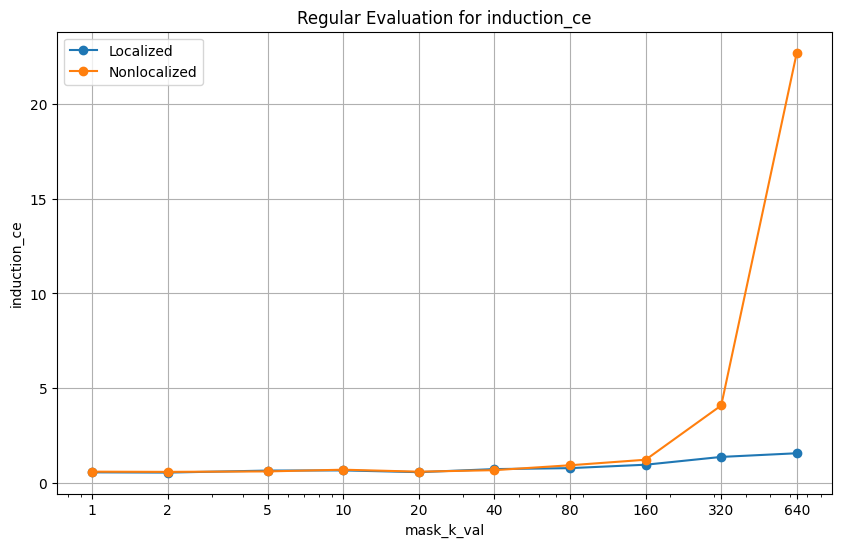

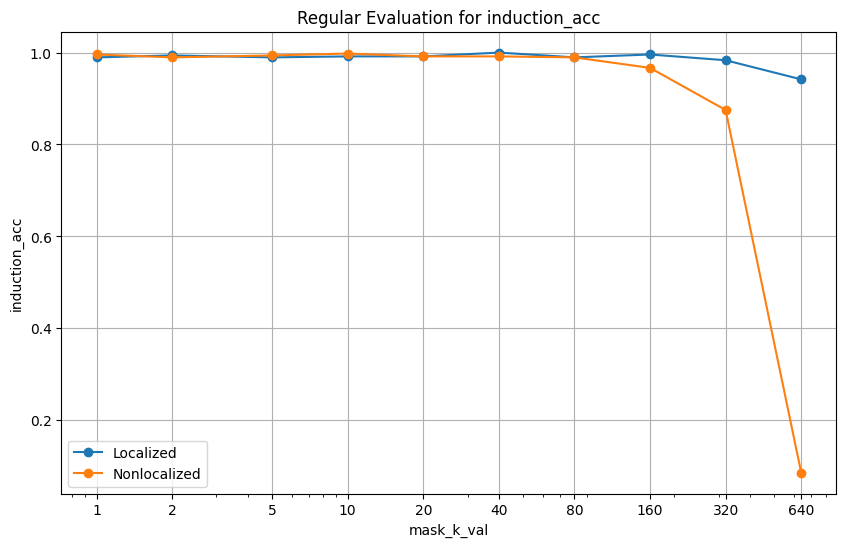

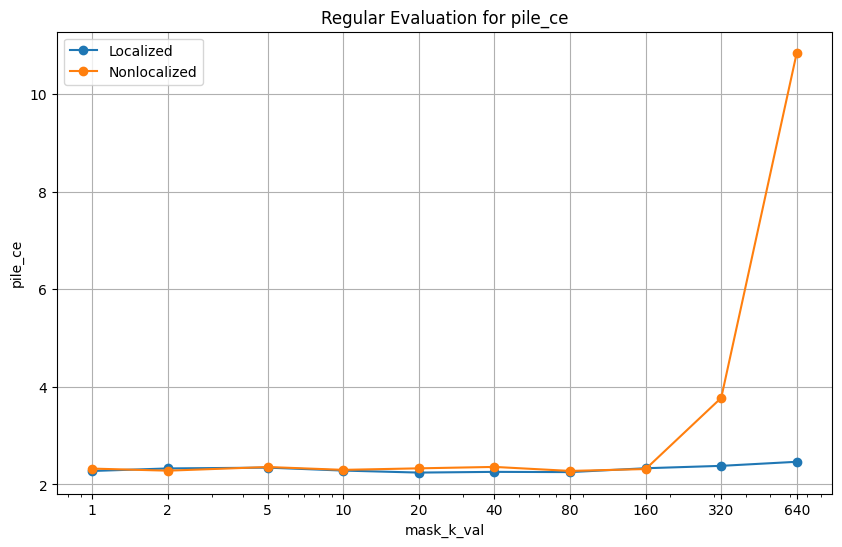

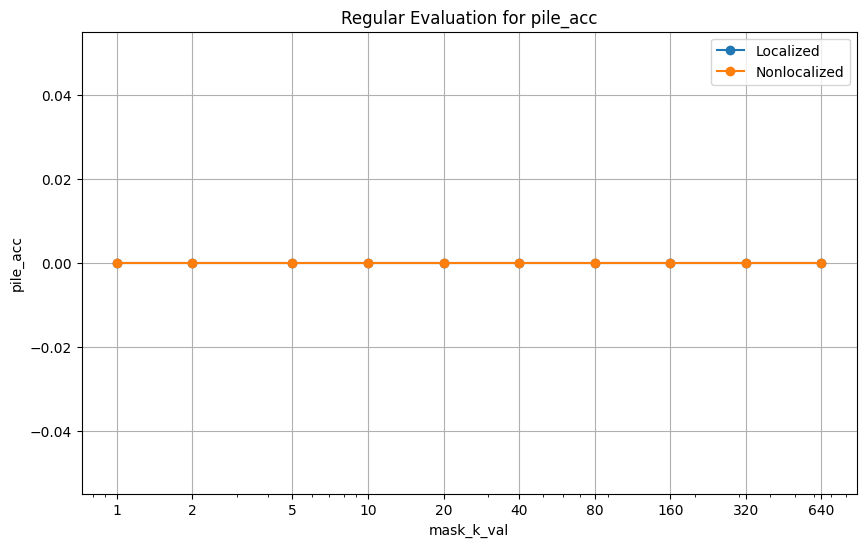

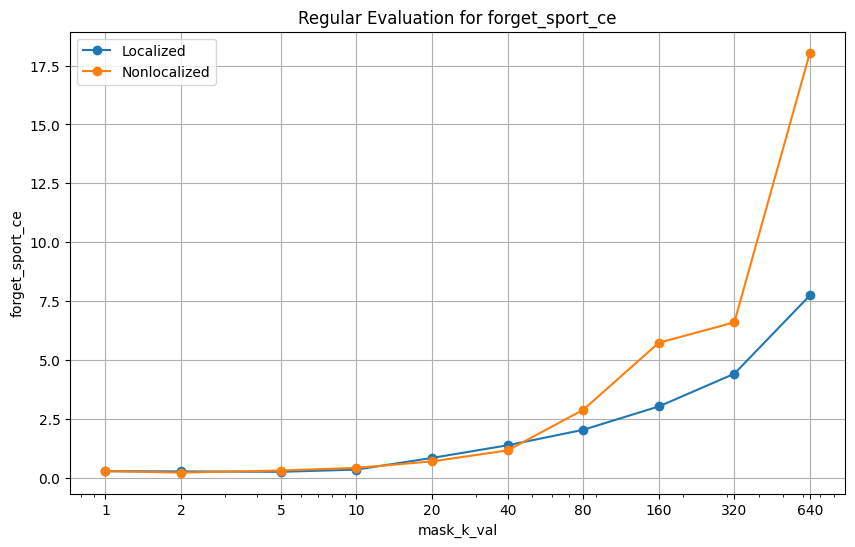

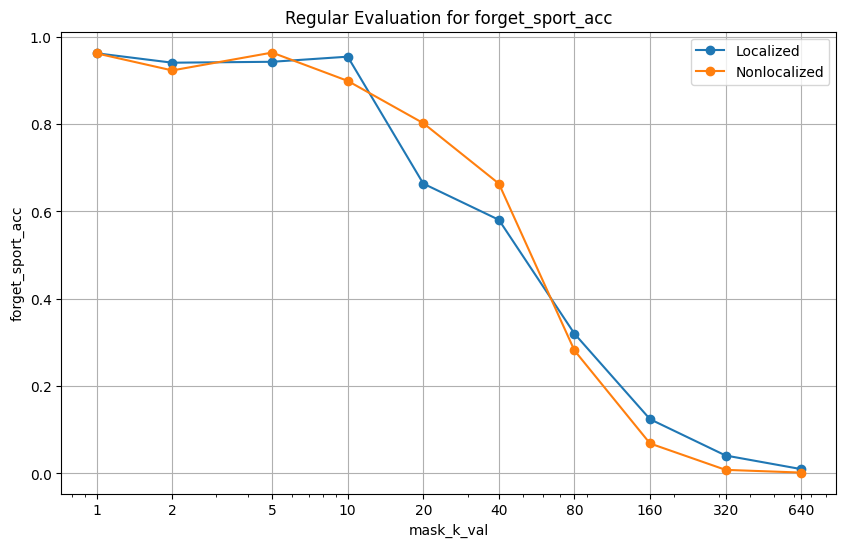

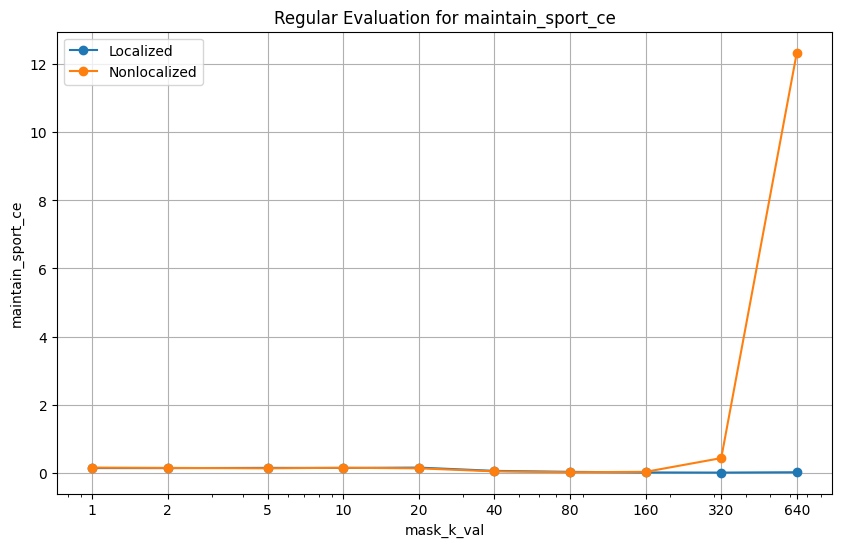

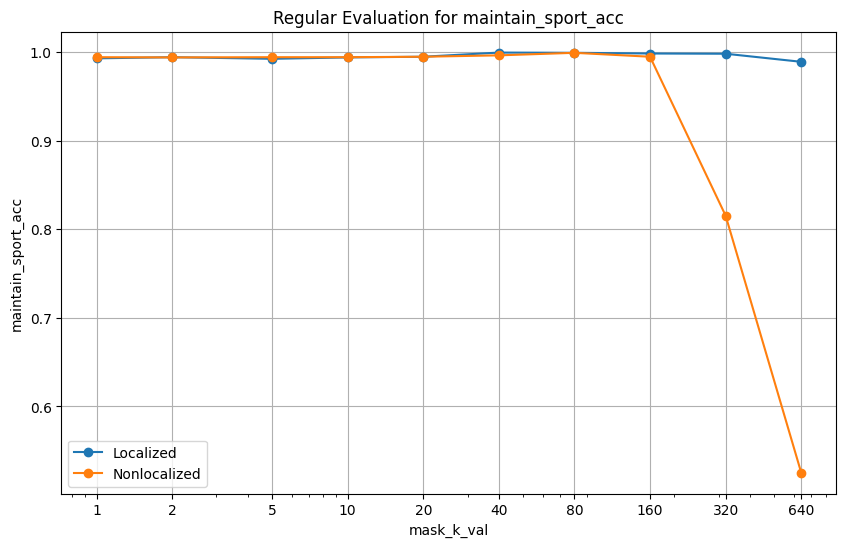

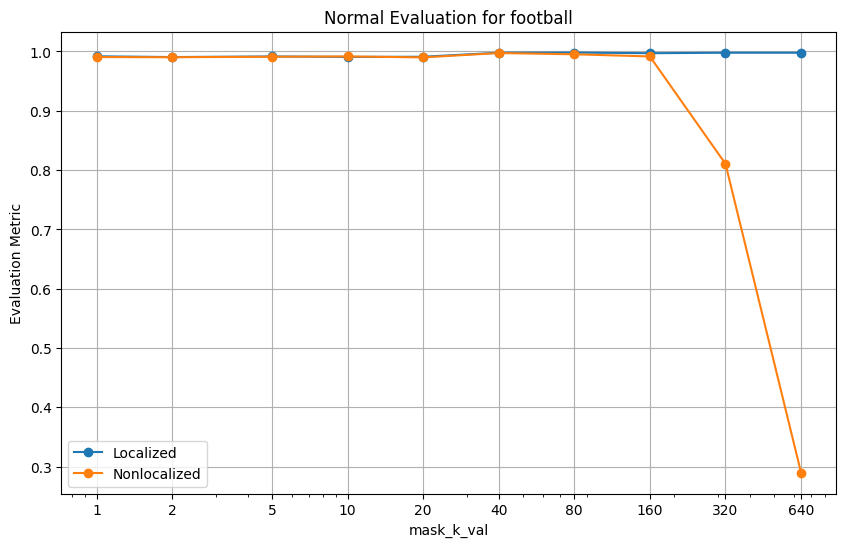

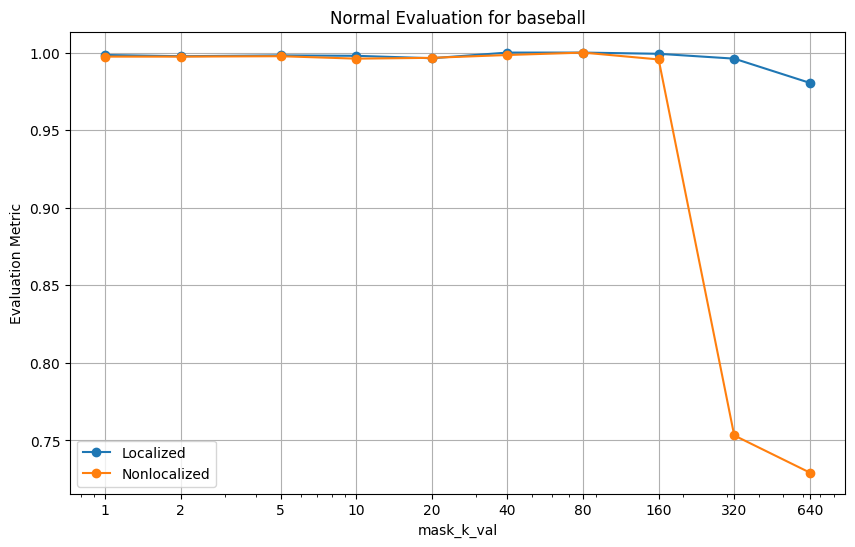

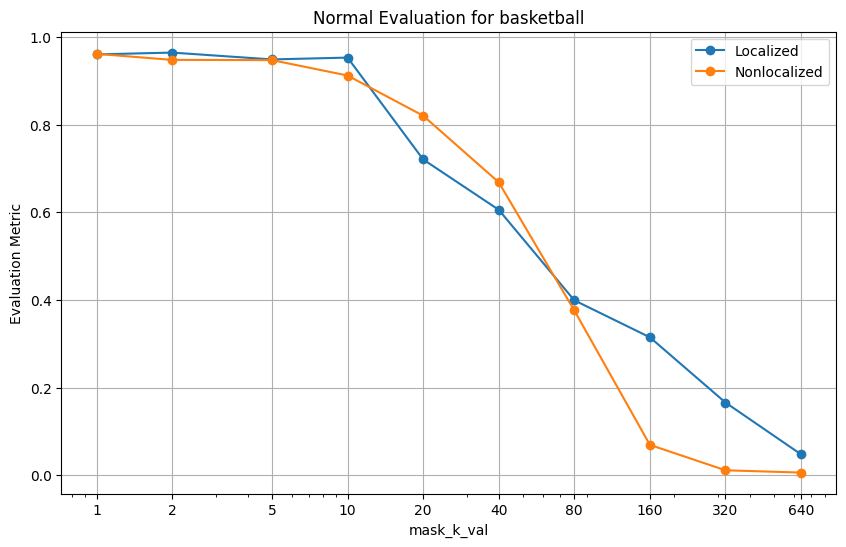

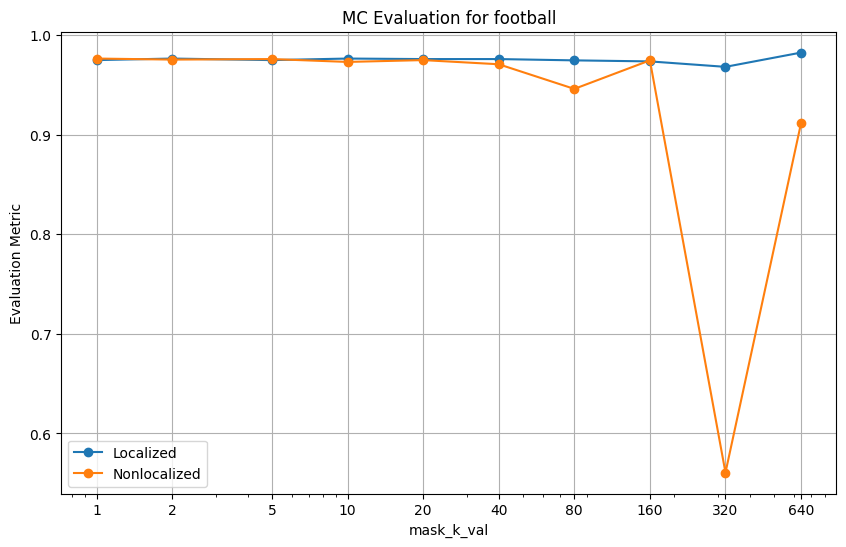

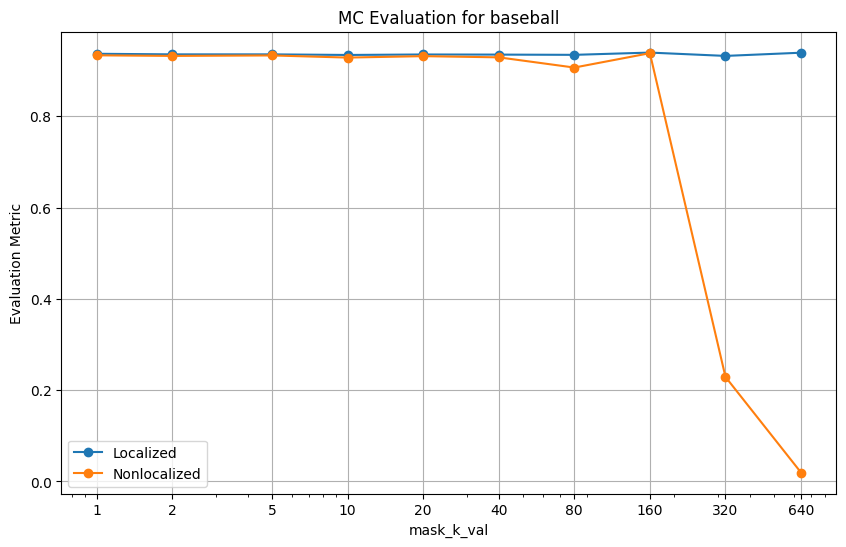

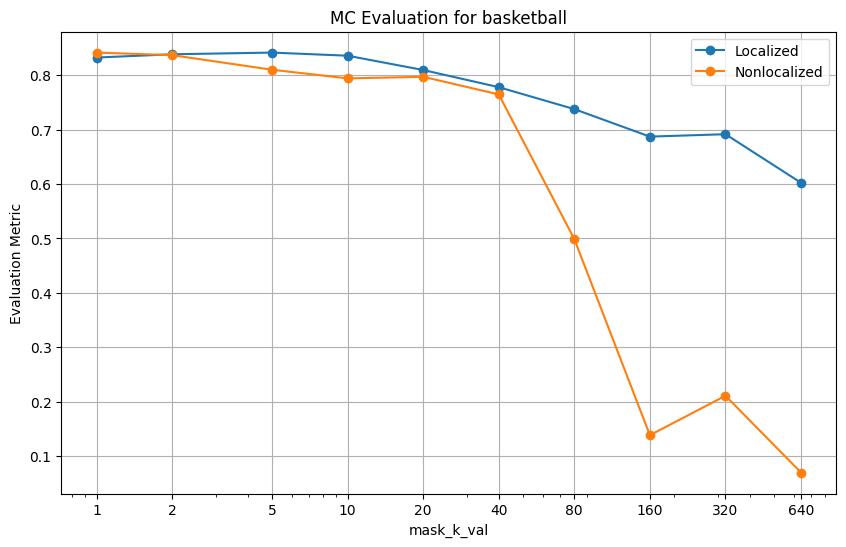

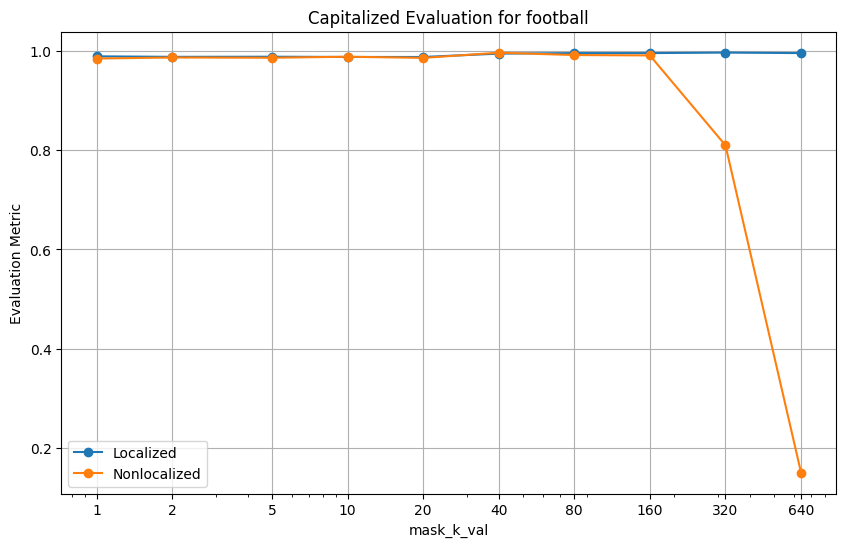

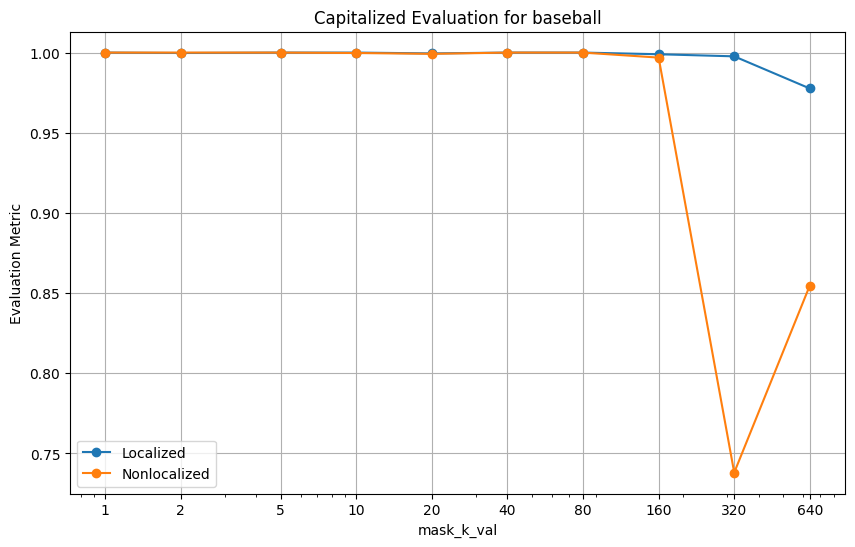

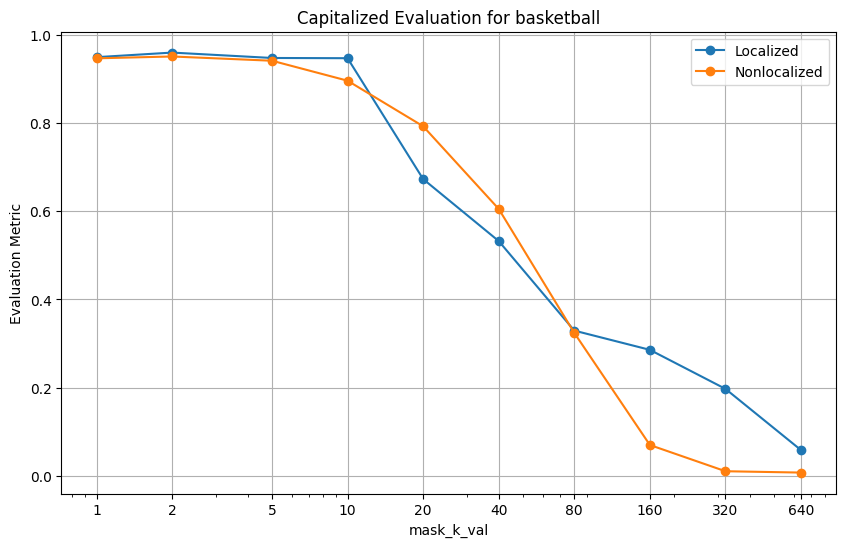

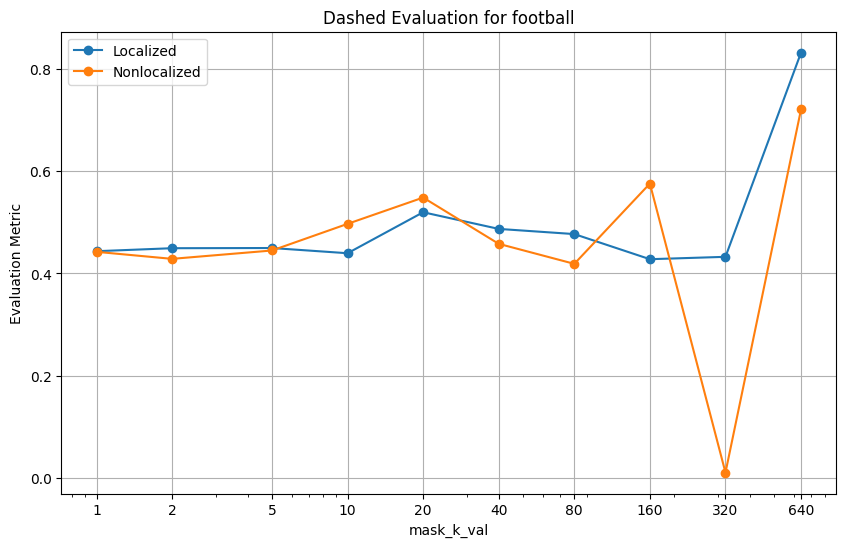

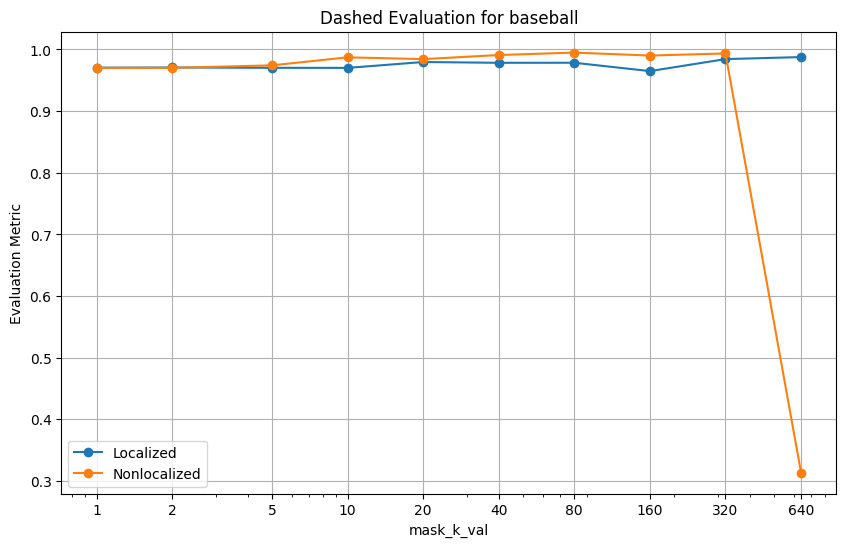

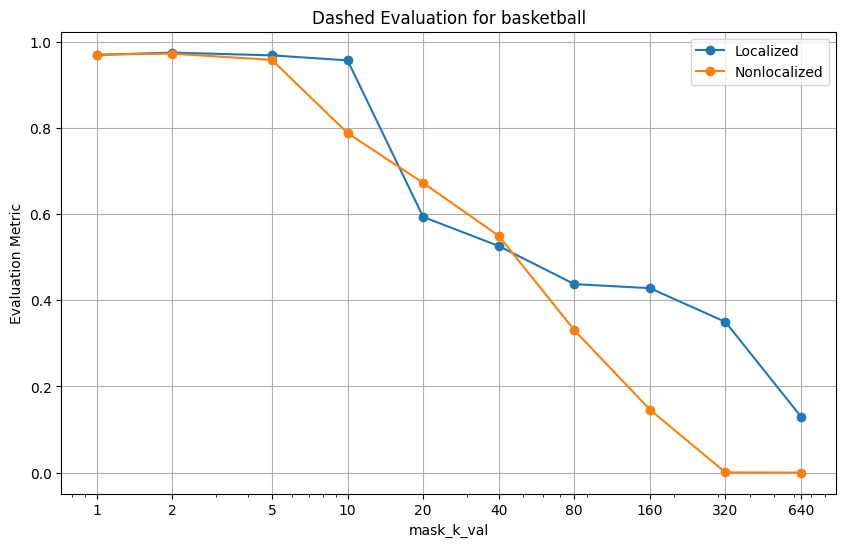

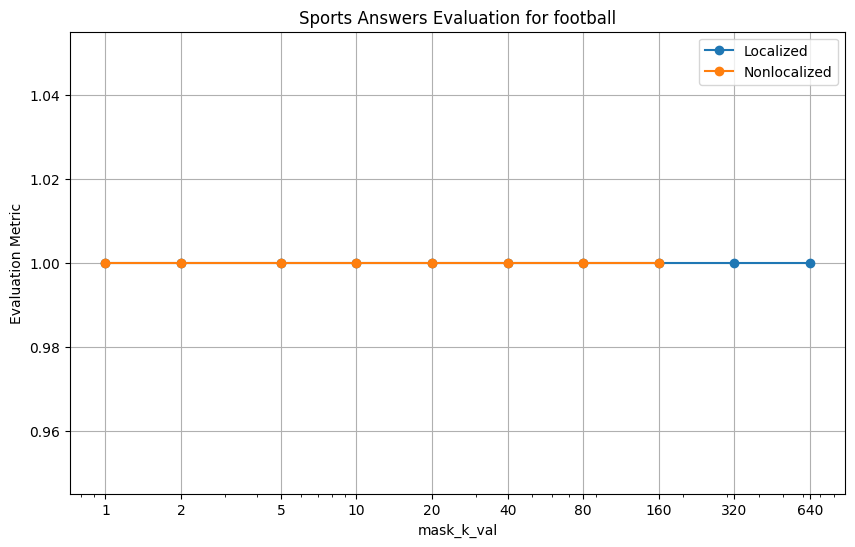

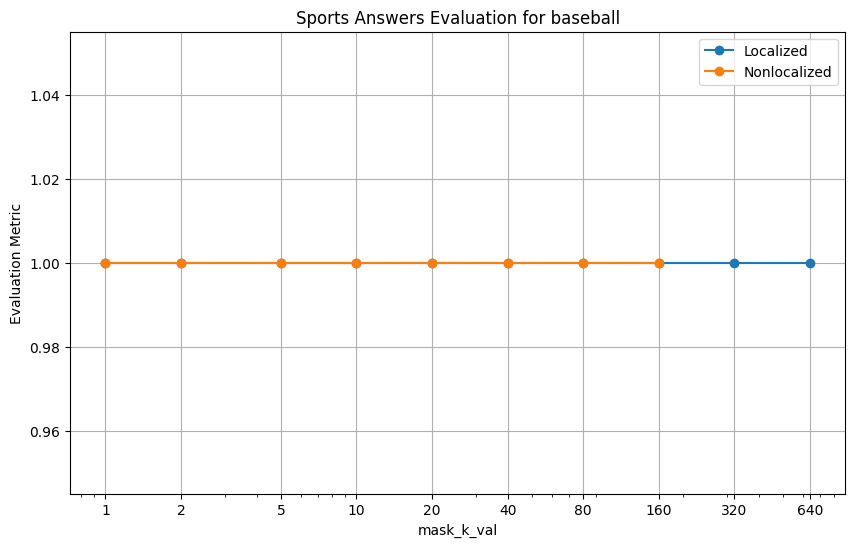

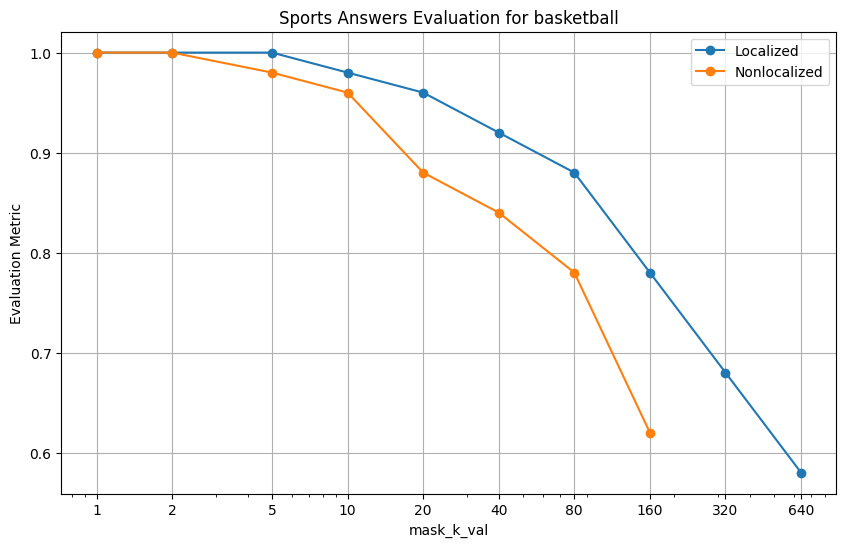

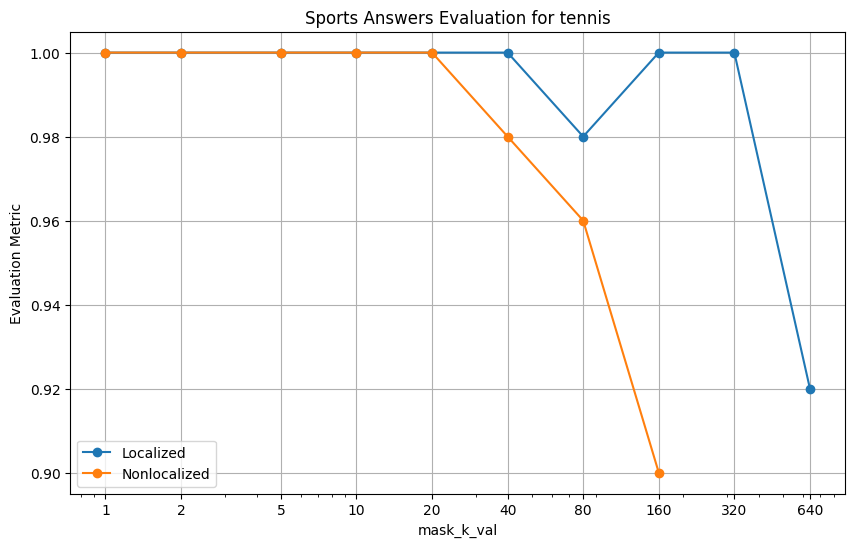

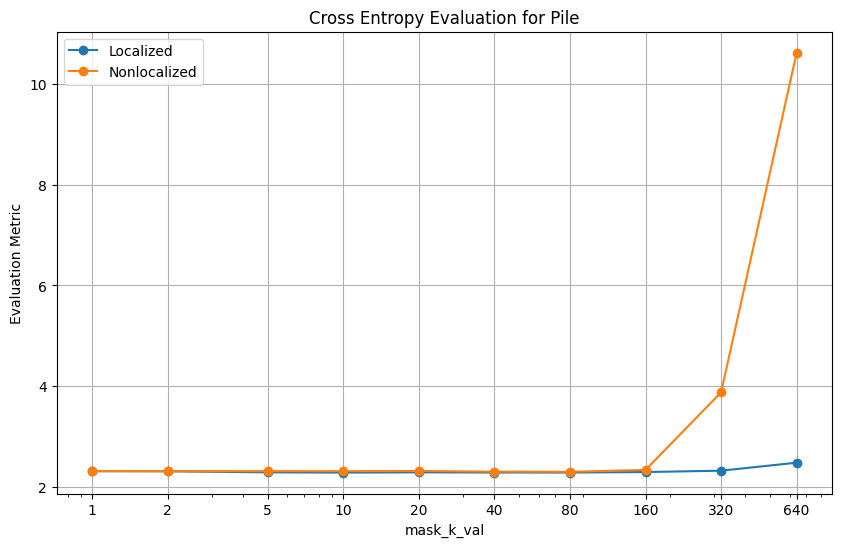

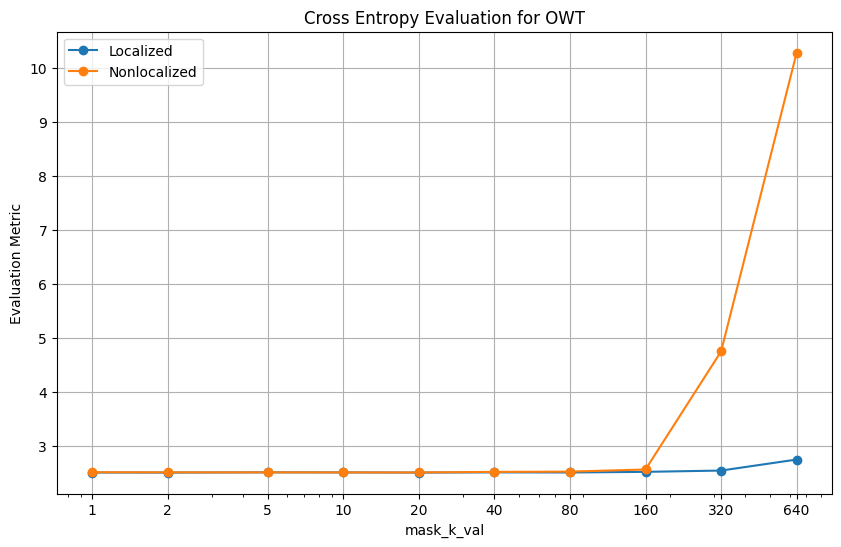

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_regular_evaluations(localized_evals, nonlocalized_evals, task_name, y_label="Evaluation Metric"):
    mask_k_vals = sorted(localized_evals.keys())
    localized_scores = [localized_evals[k][task_name] for k in mask_k_vals]
    nonlocalized_scores = [nonlocalized_evals[k][task_name] for k in mask_k_vals]

    plt.figure(figsize=(10, 6))
    plt.plot(mask_k_vals, localized_scores, label='Localized', marker='o')
    plt.plot(mask_k_vals, nonlocalized_scores, label='Nonlocalized', marker='o')
    plt.xlabel('mask_k_val')
    plt.ylabel(y_label)
    plt.title(f'Regular Evaluation for {task_name}')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.xticks(mask_k_vals, labels=mask_k_vals)  # Ensure ticks are set correctly for log scale
    plt.show()

def plot_nested_evaluations_with_checks(localized_evals, nonlocalized_evals, eval_type, nested_key):
    mask_k_vals = sorted(localized_evals.keys())
    localized_scores = []
    nonlocalized_scores = []

    for k in mask_k_vals:
        # Check and append localized scores
        if eval_type in localized_evals[k] and nested_key in localized_evals[k][eval_type]:
            localized_scores.append(localized_evals[k][eval_type][nested_key])
        else:
            localized_scores.append(None)  # or use -1 or np.nan

        # Check and append nonlocalized scores
        if eval_type in nonlocalized_evals[k] and nested_key in nonlocalized_evals[k][eval_type]:
            nonlocalized_scores.append(nonlocalized_evals[k][eval_type][nested_key])
        else:
            nonlocalized_scores.append(None)  # or use -1 or np.nan

    plt.figure(figsize=(10, 6))
    plt.plot(mask_k_vals, localized_scores, label='Localized', marker='o')
    plt.plot(mask_k_vals, nonlocalized_scores, label='Nonlocalized', marker='o')
    plt.xlabel('mask_k_val')
    plt.ylabel('Evaluation Metric')
    plt.title(f'{eval_type} Evaluation for {nested_key}')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.xticks(mask_k_vals, labels=mask_k_vals)  # Ensure ticks are set correctly for log scale
    plt.show()

# Plotting regular evaluations
# for task in ['induction', 'pile', 'forget_sport', 'maintain_sport']:
for task in localized_regular_evals[mask_k_vals[0]].keys():
    plot_regular_evaluations(localized_regular_evals, nonlocalized_regular_evals, task, y_label=task)

# Plotting adversarial evaluations
# for eval_type in ['Normal', 'MC', 'Capitalized', 'Dashed']:
for eval_type in localized_adversarial_evals[mask_k_vals[0]].keys():
    # for sport in ['football', 'baseball', 'basketball']:
    for sport in localized_adversarial_evals[mask_k_vals[0]][eval_type].keys():
        plot_nested_evaluations_with_checks(localized_adversarial_evals, nonlocalized_adversarial_evals, eval_type, sport)

# Plotting side effect evaluations with checks for missing keys
for eval_type in ['Sports Answers', 'Cross Entropy']:
    if eval_type == 'Sports Answers':
        for sport in ['football', 'baseball', 'basketball', 'tennis']:
            plot_nested_evaluations_with_checks(localized_side_effect_evals, nonlocalized_side_effect_evals, eval_type, sport)
    elif eval_type == 'Cross Entropy':
        for category in ['Pile', 'OWT']:
            plot_nested_evaluations_with_checks(localized_side_effect_evals, nonlocalized_side_effect_evals, eval_type, category)